In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import r2_score, precision_recall_fscore_support, balanced_accuracy_score

import pandas as pd
import numpy as np

from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re
from datetime import datetime

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

import seaborn as sns

In [167]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [191]:
def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features

def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

#     ret = False
    local_feature_count = 0
    for tok in splitted_rule:
        if tok.strip() in top_k_global_features:
#             ret = True
#             break
            local_feature_count = local_feature_count+1
    local_feature_ratio = local_feature_count/len(splitted_rule)
#     return ret
    return local_feature_ratio
    
def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [198]:
# '''
#     synthetic_inst1: generated instance used with global model
#     synthetic_inst2: generated instance used with local model
#     global_model, local_model: any sklearn ML model or ML model that is extended from ML model
# '''
# def cal_bal_acc(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([True, False]):
#         local_pred = np.round(local_pred)
#         local_pred = [True if val else False for val in local_pred]
        
#     bal_acc = balanced_accuracy_score(global_pred, local_pred)
#     return bal_acc
    
# def cal_r2_score(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     global_pred = [1 if val else 0 for val in global_pred]
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([1, 0]):
#         local_pred = np.round(local_pred)
#         local_pred = [1 if val else 0 for val in local_pred]
        
#     r2_scr = r2_score(global_pred, local_pred)
#     return r2_scr

def eval_local_model(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]

    top_k_global_features = get_top_k_global_features(global_model, indep)
    print(top_k_global_features)
    total_top_k_global_features = len(top_k_global_features)

    py_exp_is_in_top_k_global_features_count = 0
    lime_exp_is_in_top_k_global_features_count = 0

    # project, commit id , method, euc_dist_mean, euc_dist_med, defective_generated_instance_ratio
    # bal_acc, r2_score

    # one dataframe for every RQ and every METHOD !!!!
    all_eval_result = pd.DataFrame()

    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
    #     y_explain = test_label.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model'] 
        # this data can be used with lobal model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        X_explain = X_explain.values

        # make a prediction for later use
        py_exp_global_pred = global_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_pred = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_pred)


        # for RQ1 (single numeric value)
        py_exp_dist = euclidean_distances(X_explain, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        # for RQ1 (single numeric value)
        py_exp_def_pred_ratio = np.sum(py_exp_local_pred)/len(py_exp_local_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_local_pred)/len(lime_exp_local_pred)

        # for RQ2 (single numeric value)
        py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        lime_exp_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        # for RQ3 (single numeric value)
        py_exp_r2_scr = r2_score(py_exp_global_pred, py_exp_local_pred)
        lime_exp_r2_scr = r2_score(lime_exp_global_pred, lime_exp_local_pred)

        # for RQ4 (single numeric value)
        # no need to store value in dataframe
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_exp_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_is_in_top_k_global_features = is_in_top_k_global_features(top_k_global_features, 
                                                                         py_exp_the_best_defective_rule_str)
        lime_exp_is_in_top_k_global_features = is_in_top_k_global_features(top_k_global_features, 
                                                                           lime_exp_the_best_defective_rule_str)

        if py_exp_is_in_top_k_global_features > 0:
            py_exp_is_in_top_k_global_features_count = py_exp_is_in_top_k_global_features_count+1
        if lime_exp_is_in_top_k_global_features > 0:
            lime_exp_is_in_top_k_global_features_count = lime_exp_is_in_top_k_global_features_count+1

        # column: project, commit id , method, euc_dist_mean, euc_dist_med, defective_generated_instance_ratio
        # bal_acc, r2_score
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_dist_mean, 
                                       py_exp_dist_med, py_exp_def_pred_ratio, py_exp_bal_acc, 
                                       py_exp_r2_scr, py_exp_is_in_top_k_global_features])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_exp_dist_mean, 
                                         lime_exp_dist_med, lime_exp_def_pred_ratio, lime_exp_bal_acc, 
                                         lime_exp_r2_scr, lime_exp_is_in_top_k_global_features])

        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

        print('finished',row_index)
    #     break

    all_eval_result.columns=['project', 'commit id', 'method', 'euc_dist_mean', 'euc_dist_med', 
                             'defective_generated_instance_ratio', 'bal_acc', 'r2_score', 'local_feature_ratio']

    all_eval_result.to_csv('./eval_result/'+proj_name+'_RQ1_RQ4_eval.csv',index=False)
    
    print('finished evaluation')
    print('ratio of test instances of py_exp that their features in the rules appear in global feature', 
          py_exp_is_in_top_k_global_features_count/len(feature_df))
    print('ratio of test instances of LIME that their features in the rules appear in global feature',
          lime_exp_is_in_top_k_global_features_count/len(feature_df))

In [200]:
eval_local_model('openstack')

['ent', 'nrev', 'la', 'app', 'rtime']
finished 1e6973aee7137653c62dcef970b1e2527b50517d
finished 5d0ccceb20780fdd3adf519d3f8e6b80b1844407
finished de31210c05f464c4a79255de68b1a515d9b84ed3
finished 957533f685caf9ffc0d9cad569598455d59ade34
finished 96677735f6d8f1f5b6380127956921f719aab799
finished 10593c2eaf4eff4edb13b70f023acbbf743f129f
finished 8db51da1e25f1c148fbe8d8f27d144a39d1850f3
finished ba4ed39616c3c6fabf24ca390c7037877c672fba
finished 2c62e344e26ccba08d5c613a7c4a40a0f076901e
finished 207a7825fbcc69c4c3d4bfefd8e9c33978162ed9
finished 03a41f863b160384593ef8df130f369a0c22d393
finished f0ce71c23c786baf7c828d1fd147d70342593a10
finished b199471154cb4be2d7d9c89939bb31e90f3adff4
finished 608c67439c8fcfa1a2fddd1087ca1fe998a8f9fd
finished 1e90eb66ae999201a0b3d2e7409734c3e2f452d7
finished e8440d1ee8da2cbf4304bbbc0bf43ce78d7a6d1f
finished a9230a38977d6acb804ee8bb6f58c19957dce013
finished e3e4f4d9277c22654ce0dd9a1a0f44a67661e695
finished b6133c35dd587f6b01e8ec12757347b2767713a6
finished 262

finished 7255e056092f034daaeb4246a812900645d46911
finished f7fcb809f097cb84e07e2d0093cc9af92c82d29d
finished 4711ff3adff2b4c9a54f5fb4448ace6558f82f6b
finished 9271e300a55f8aa16ff867fff71adadb383849b8
finished 55b54ac9e6b9b83f837e1bf6eaed2be2cce5aab9
finished f8ab9d4366c87724cba2e49e71dc72e2427d5a68
finished bcd9f363ff8a10ff30795c54f471a8c6d76450fe
finished 41e3a94ae18a9219ff4ab10389f3a7799c9b6493
finished b7b0c7dbcd3e6754bc09b2fd75d888c41ae4aadb
finished 901b303f1e836421c16f914d3d60b6c9caabefde
finished 5a7808d676a844c5c1327bd59ec184e26e0546b1
finished 2bfc7171c23d0595aa7f8680271778bc58cb28ba
finished 132f13e5b095bdeaa0db72b151a3bf912ccfca36
finished 4c1b1a893e82f045f5c6c7c9d7b019ddb01cb425
finished e6c0f9c1685e4ffbd72ae75808361252652b7fc2
finished c823016d31b36c10cb6faafcce68a1b98f4dc345
finished e6a3206523b8e1a4edd8867a8e7e36a58631d90a
finished a234ecda87f803b05637f3d74ba53815f20f472f
finished 77821190873a415e2fef445474d997103c8d5651
finished 749b5b98859685d72ebfc684f8066ea138f8b76b


In [199]:
# all_eval_result.columns=['project', 'commit id', 'method', 'euc_dist_mean', 'euc_dist_med', 
#                          'defective_generated_instance_ratio', 'bal_acc', 'r2_score', 'local_feature_ratio']
# print(all_eval_result.head())
# all_eval_result.to_csv('./eval_result/'+proj_name+'_RQ1_RQ4_eval.csv',index=False)
eval_local_model('qt')

['nrev', 'ent', 'la', 'ndev', 'hcmt']
finished f5dbc876378ae58a7bdfe1e9664fc81caca18dfb
finished 602bd9873786ccadcb67da3036329f3122555cf8
finished 9d75626b1073113d77988bcb52e99215d5af4787
finished 3168c94577cc604fd033ce4e741da5c411f74666
finished 23bdca417bde716c79168ab372083fd885607123
finished 438211ec627073817fcaf6d3a07b76f2aa5d90e0
finished d8090022f66cc6cff6af5ed2ae702212fd172ff7
finished 06eaeb0ac8d861cf3e60b11a8fbbabdeef1d6759
finished 4dbf574b7acb7ae8f852219700afa95f8d568f0e
finished 2eb28f51ce4150fa03b2ddde8c39b502ae57d18a
finished 61b56a89a1cf8a388ff925492700e5eef019c3aa
finished 07860794da5863610f38295c9d517fc457c5de95
finished b508dc98a5085df6ea44b154177fbb6d8b0e8434
finished b449791c3565940e701c68b3f705014804af0c2b
finished 3abecf2ee9fc724af571f8c7da4302f7bee9eadb
finished d8d903826daa8db49e437b76fb80693ab8feb01e
finished 5b456c8da4462f9e11fa4da78a9e6ea86423a1e8
finished 37ca2224eca671200a2710f57f970d2993e62aa5
finished fd619946be51784dc709363324897be6af144c52
finished 0ed

In [95]:
print(py_exp_is_in_top_k_global_features_count/len(feature_df), 
      lime_exp_is_in_top_k_global_features_count/len(feature_df))

0.7341772151898734 0.5949367088607594


In [172]:
# proj_name = 'openstack'
openstack_result_df = pd.read_csv('./eval_result/openstack_RQ1_RQ4_eval.csv')
qt_result_df = pd.read_csv('./eval_result/qt_RQ1_RQ4_eval.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
print(len(result_df))

554


In [142]:
print(openstack_result_df.head())

     project                                 commit id  \
0  openstack  1e6973aee7137653c62dcef970b1e2527b50517d   
1  openstack  1e6973aee7137653c62dcef970b1e2527b50517d   
2  openstack  5d0ccceb20780fdd3adf519d3f8e6b80b1844407   
3  openstack  5d0ccceb20780fdd3adf519d3f8e6b80b1844407   
4  openstack  de31210c05f464c4a79255de68b1a515d9b84ed3   

                    method  euc_dist_mean  euc_dist_med  \
0  crossover_interpolation     402.001480    331.704115   
1                     LIME     891.144954    547.648247   
2  crossover_interpolation     563.188939    488.590016   
3                     LIME    1372.434025   1384.777800   
4  crossover_interpolation     296.285365    233.747669   

   defective_generated_instance_ratio   bal_acc  r2_score  local_feature_ratio  
0                            0.431452  0.914181  0.664601                  0.4  
1                            0.050800  0.579753 -0.126152                  0.2  
2                            0.689435  1.000000  1.00

<AxesSubplot:xlabel='project', ylabel='euc_dist_med'>

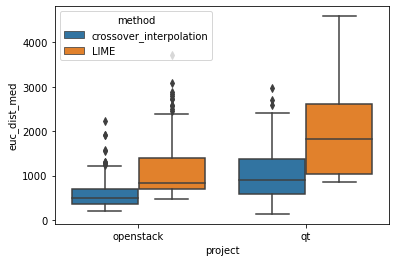

In [173]:
# RQ1: euc_dist_med
sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method')

<AxesSubplot:xlabel='project', ylabel='defective_generated_instance_ratio'>

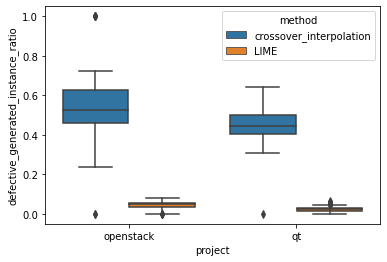

In [174]:
# RQ1: defective_generated_instance_ratio
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method')

<AxesSubplot:xlabel='project', ylabel='bal_acc'>

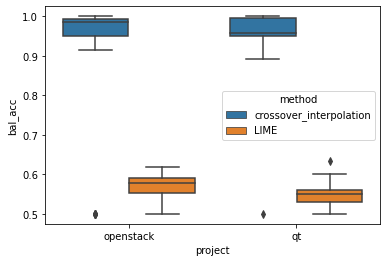

In [175]:
# RQ2: bal_acc
sns.boxplot(data=result_df, x='project', y='bal_acc', hue='method')

<AxesSubplot:xlabel='project', ylabel='r2_score'>

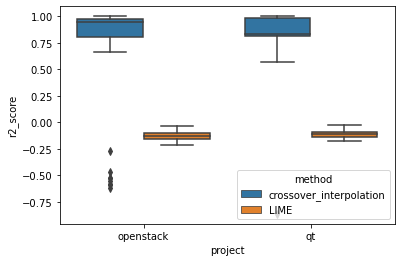

In [176]:
# RQ3: r2_score
sns.boxplot(data=result_df, x='project', y='r2_score', hue='method')

     project                   method     ratio
0  openstack  crossover_interpolation  0.848400
1  openstack                     LIME  0.979797
2         qt  crossover_interpolation  0.734120
3         qt                     LIME  0.594936


<AxesSubplot:xlabel='project', ylabel='ratio'>

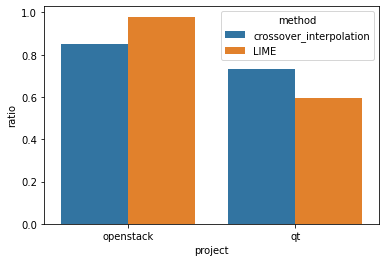

In [112]:
# RQ4: ratio of rules of which features appear in top-k global feature
rq4_df = pd.DataFrame()
rq4_df = rq4_df.append(pd.Series(['openstack','crossover_interpolation',0.8484]), ignore_index=True)
rq4_df = rq4_df.append(pd.Series(['openstack','LIME',0.979797]), ignore_index=True)
rq4_df = rq4_df.append(pd.Series(['qt','crossover_interpolation',0.73412]), ignore_index=True)
rq4_df = rq4_df.append(pd.Series(['qt','LIME',0.594936]), ignore_index=True)

rq4_df.columns = ['project','method','ratio']
print(rq4_df)

sns.barplot(data=rq4_df, x="project", y="ratio", hue="method")

<AxesSubplot:xlabel='project', ylabel='local_feature_ratio'>

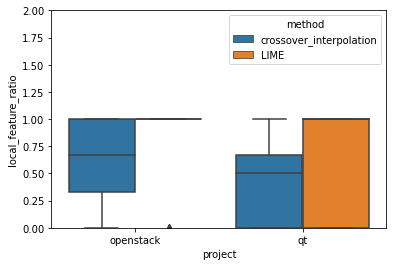

In [179]:
# RQ4 (new)
plt.ylim(0,2)
sns.boxplot(data=result_df, x='project', y='local_feature_ratio', hue='method')

In [189]:
print(np.median(result_df[(result_df['project']=='qt') & (result_df['method']=='LIME')]['local_feature_ratio']))

1.0


In [69]:

# change param here, no need to loop :)
# proj_name = 'openstack' # ['openstack','qt']
# instance_generation_mode = 'randompertubation' # ['randompertubation','crossoverinterpolation']
# explainer_type = 'rulefit' # ['rulefit', LRR', 'BRCG']

## local model explainer evaluation step

1. load global model
2. load prediction result
3. create pyExplainer object (for later use)
4. load object obained from pyExplainer
5. perform evaluation of each research question

In [82]:
class PyExplainer_Evaluation:

    def __init__(self, proj_name):
        self.data_path = './dataset/'
        self.result_dir = './eval_result/'
        self.dump_dataframe_dir = './dump_df/'
        self.pyExp_dir = './pyExplainer_obj/'
        self.other_object_dir = './other_object/'
        self.generated_instance_dir = './generated_instance/'
    
        self.proj_name = proj_name
        
        if not os.path.exists(self.generated_instance_dir):
            os.makedirs(self.generated_instance_dir)

    def prepare_data_for_evaluation(self):
        x_train, y_train = prepare_data(self.proj_name, mode = 'train')

        self.global_model = pickle.load((open(self.proj_name+'_global_model.pkl','rb')))

        '''
            prediction result is in 'pred' column
            prediction prob of buggy commit is in 'defective_prob' column
            label is in 'defect' column
        '''
        correctly_predicted_result = pd.read_csv(self.dump_dataframe_dir+self.proj_name+'_correctly_predict_as_defective.csv')
        self.correctly_predicted_result = correctly_predicted_result.set_index('commit_id')

        self.dep = 'defect'
        self.indep = self.correctly_predicted_result.columns[:-3]
        self.class_label = ['clean', 'defect']

        self.feature_df = correctly_predicted_result.loc[:, self.indep]
        self.test_label = correctly_predicted_result.loc[:, self.dep]
        
        self.pyExp = PyExplainer(x_train, y_train, self.indep, self.dep, self.class_label, 
                                 blackbox_model = self.global_model, categorical_features = ['self'])
        
        print('prepare data finished')
        
    def get_top_k_global_features(self, top_k_global_feature_num = 5):
        global_feature_df = pd.DataFrame()
        global_feature_df['feature'] = self.indep
        global_feature_df['importance'] = self.global_model.feature_importances_

        global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

        top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]
        
        return top_k_global_features
    #     display(global_feature_df)
    #     print(top_k_global_features)

    def get_py_obj_file_str_list(self, explainer_type, instance_generation_mode):
        all_pyExp_obj_name = os.listdir(self.pyExp_dir)
#         print(all_pyExp_obj_name)
#         print(self.proj_name+'_'+explainer_type+'_'+instance_generation_mode+'_*')
        r = re.compile(self.proj_name+'_'+explainer_type+'_'+instance_generation_mode+'_*')
        py_obj_file_str_list = list(filter(r.match, all_pyExp_obj_name))
#         print(py_obj_file_str_list)
        return py_obj_file_str_list

    '''
        rule: rule object from RuleFit
        instance: generated instance
        pred: prediction of generated instance
    '''
    def eval_rule(self, rule, instance, pred):

        # check which instance contains the rule
        # may change how to get this...
        rule_result = rule.transform(instance.values) # this is p 
    #     print(rule_result)
    #     prediction_from_rule = int(round(rule.prediction_value))
    #     print('prediction_from_rule:', rule.prediction_value)
    #     prediction_from_rule = 1 if prediction_from_rule >= 0.5 else 0 


    #     rule_result_df = pd.DataFrame({'rule_result':rule_result, 'consequence':consequence})
        all_rows = len(rule_result)
        support_p = np.sum(rule_result)/all_rows # this is coverage

    #     if prediction_from_rule == 1:
        support_q = np.sum(pred)/all_rows
    #         support_pq = np.sum((rule_result==1) & (consequence==True))/all_rows
    #     else:
    #         consequence = (np.array([prediction_from_rule]*len(instance))==0) & (pred==0) # how many q is found in prediction from global model
    #         support_q = (len(pred)-np.sum(pred))/all_rows

        support_pq = np.sum((rule_result==1) & (pred==1))/all_rows

        confidence = support_pq/support_p if support_p > 0 else 0
        lift = support_pq/(support_p*support_q) if support_p > 0 and support_q > 0 else 0

    #     print(support_p, support_q, support_pq, confidence, lift)
        return support_p, confidence, lift

    '''
        input:
            rules: RuleFit.rule_ensemble.rules object (set of rules)
            the_best_defective_rule_str: string of defective rule object
        return:
            rule object that matchs the_best_defective_rule_str
    '''
    def get_the_best_rule_obj(self, rules, the_best_defective_rule_str):
        rule_obj = None
        for j in range(0,len(rules)):
            rule = rules[j]
            rule_str = str(rule).strip()

    #         print(rule_str)
            if rule_str == the_best_defective_rule_str.strip():
                rule_obj = rule
    #             print('found', rule_str)
                break
        return rule_obj

    def is_in_top_k_global_features(self, top_k_global_features, the_best_defective_rule_str):
        # remove numeric value
        new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

        # remove special characters
        new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
        splitted_rule = new_the_best_defective_rule_str.split()
    #     print(the_best_defective_rule_str)
    #     print(new_the_best_defective_rule_str)
    #     print(new_the_best_defective_rule_str.split())

        ret = False
        for tok in splitted_rule:
            if tok.strip() in top_k_global_features:
                ret = True
                break
        return ret

    # RQ1
    def find_quality_of_generated_neighbors(self, instance_generation_mode):
#         cos_sim_df = pd.DataFrame([])
        euc_dist_df = pd.DataFrame([])

#         cos_sim_mean = []
#         cos_sim_med = []
#         cos_sim_max = []

        euclid_dist_mean = []
        euclid_dist_med = []
        euclid_dist_max = []
        commit_id_list = []
        defective_ratio_list = []
        
        method = ''
        if instance_generation_mode == 'randompertubation':
            method = 'rand'
        elif instance_generation_mode == 'crossoverinterpolation':
            method = 'crossover'

        for i in range(0,len(self.correctly_predicted_result)):
            serie_name = str(self.correctly_predicted_result.iloc[i].name)
            sample_instance = self.feature_df.iloc[[i]]
    #         print(sample_instance.columns)
            y_explain = self.test_label.iloc[[i]]

        #     synthetic_instances = pickle.load(open('./generated_instance_for_RuleFit/'+proj_name+'_'+method+'_'+serie_name+'.pkl','rb'))

            file_path = self.generated_instance_dir+self.proj_name+'_'+instance_generation_mode+'_'+serie_name+'.pkl'
            if os.path.exists(file_path):
                synthetic_instances = pickle.load(open(file_path,'rb'))
    #             print('load from file')

            else:
                if instance_generation_mode == 'randompertubation':
                    synthetic_instances = self.pyExp.generate_instance_random_pertubation(sample_instance, y_explain)['synthetic_data']
                elif instance_generation_mode == 'crossoverinterpolation':
                    synthetic_instances = self.pyExp.generate_instance_crossover_interpolation(sample_instance, y_explain)['synthetic_data']

                pickle.dump(synthetic_instances, open(file_path,'wb'))

#             cos_sim = cosine_similarity(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]
                
            synt_pred = self.global_model.predict(synthetic_instances)
            euclid_dist = euclidean_distances(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]

#             print('-------------sample instance-------------')
#             display(sample_instance)
#             print('-------------synthetic instances-----------')
#             display(synthetic_instances)
            
#             cos_sim_mean.append(np.mean(cos_sim))
#             cos_sim_med.append(np.median(cos_sim))
#             cos_sim_max.append(np.max(cos_sim))

            commit_id_list.append(serie_name)
            euclid_dist_mean.append(np.mean(euclid_dist))
            euclid_dist_med.append(np.median(euclid_dist))
            euclid_dist_max.append(np.max(euclid_dist))
            defective_ratio_list.append(np.sum(synt_pred)/len(synt_pred))
#             print(synt_pred)
            
#             break

#         cos_sim_df[method+'_mean'] = cos_sim_mean
#         cos_sim_df[method+'_med'] = cos_sim_med
#         cos_sim_df[method+'_max'] = cos_sim_max

        euc_dist_df['project'] = [self.proj_name]*len(commit_id_list)
        euc_dist_df['commit_id'] = commit_id_list
        euc_dist_df['search_method'] = [instance_generation_mode]*len(euc_dist_df)
        euc_dist_df['dist_mean'] = euclid_dist_mean
        euc_dist_df['dist_med'] = euclid_dist_med
        euc_dist_df['dist_max'] = euclid_dist_max
        euc_dist_df['defective_ratio'] = defective_ratio_list

#         cos_sim_df.to_csv(dump_dataframe_dir+self.proj_name+'_'+instance_generation_mode+'_cosine_similarity.csv',index=False)
#         euc_dist_df.to_csv(self.dump_dataframe_dir+'RQ1_'+self.proj_name+'_'+instance_generation_mode+'_euclidean_dist.csv',index=False)

#         display(euc_dist_df)
        print('finished evaluating quality of generated neighbors of {} project, {} method'.format(self.proj_name, instance_generation_mode))

        return euc_dist_df

    # RQ2
    def find_prob_of_global_and_local_model(self, instance_generation_mode, explainer_type='rulefit'):
        global_model_prob_list = []
        local_model_prob_list = []
        idx_list = []
        
        
        py_obj_file_str = self.get_py_obj_file_str_list(explainer_type, instance_generation_mode)

        for obj_name in py_obj_file_str:
        #     cov_list, conf_list, lift_list = [], [], [] 
            
            pyExp_obj = pickle.load(open(self.pyExp_dir+obj_name,'rb')) 
            obj_idx = obj_name.replace('.pkl','').split('_')[-1]
        #     print(pyExp_obj.keys())

            local_model = pyExp_obj['local_model']
            synt_inst = pyExp_obj['synthetic_data']
#             synt_label = pyExp_obj['synthetic_predictions']
#             x_explain = pyExp_obj['X_explain']
        #     top_k_positive_rules = pyExp_obj['top_k_positive_rules']

            # for RQ 2
            global_model_prob = self.global_model.predict(synt_inst)
            local_model_prob = local_model.predict(synt_inst.values)

            global_model_prob = [1 if val else 0 for val in global_model_prob]
            local_model_prob = [1 if val else 0 for val in local_model_prob]
            
            idx_list.extend([obj_idx]*len(global_model_prob))
            global_model_prob_list.extend(list(global_model_prob))
            local_model_prob_list.extend(list(local_model_prob))

#             print(idx_list)
#             print(global_model_prob_list)
#             print(local_model_prob_list)
            
#             break
        global_prob_vs_local_prob = pd.DataFrame()
        global_prob_vs_local_prob['project'] = [self.proj_name]*len(idx_list)
        global_prob_vs_local_prob['commit_id'] = idx_list
        global_prob_vs_local_prob['search_method'] = [instance_generation_mode]*len(global_prob_vs_local_prob)
        global_prob_vs_local_prob['global'] = global_model_prob_list
        global_prob_vs_local_prob['local'] = local_model_prob_list
        global_prob_vs_local_prob['label'] = [1]*len(global_prob_vs_local_prob)

#         display(global_prob_vs_local_prob)

#         save_file_dir = self.dump_dataframe_dir+'RQ2_'+self.proj_name+'_'+instance_generation_mode+'_global_prob_vs_local_prob.csv'
#         global_prob_vs_local_prob.to_csv(save_file_dir,index=False)

        print('finished evaluating global model vs local model of {} project, {} method'.format(self.proj_name, instance_generation_mode))
#         print('write file to',save_file_dir)
#         print('-'*80)
        return global_prob_vs_local_prob

    # RQ3 + RQ4
    def eval_rule_from_local_model(self, instance_generation_mode, explainer_type='rulefit'):
        commit_id_list, cov_list, conf_list, lift_list = [], [], [], []
        count_is_appear_in_global_features = 0

        py_obj_file_str = self.get_py_obj_file_str_list(explainer_type, instance_generation_mode)
        top_k_global_features = self.get_top_k_global_features(top_k_global_feature_num = 5)

#         print(py_obj_file_str)
        
        for obj_name in py_obj_file_str:
            pyExp_obj = pickle.load(open(self.pyExp_dir+obj_name,'rb')) 
            obj_idx = obj_name.replace('.pkl','').split('_')[-1]
        #     print(pyExp_obj.keys())

            local_model = pyExp_obj['local_model']
            synt_inst = pyExp_obj['synthetic_data']
            synt_label = pyExp_obj['synthetic_predictions']
            x_explain = pyExp_obj['X_explain']


            # for RQ3 (find coverage, confidence, lift)
            # but find the best defective rule for RQ5, too. :)
            rules = local_model.rule_ensemble.rules

            rule_df = local_model.get_rules()
            top_k = 5
            top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)

            the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
            def_rule = self.get_the_best_rule_obj(rules,the_best_defective_rule_str)

        #     display(top_k_positive_rules)
        #     print(the_best_defective_rule_str)
        #     print(def_rule)
        #     print('-'*100)
            coverage, confidence, lift = self.eval_rule(def_rule, synt_inst, synt_label)
        #     print(coverage, confidence, lift)
            cov_list.append(coverage)
            conf_list.append(confidence)
            lift_list.append(lift)
            commit_id_list.append(obj_idx)
            
            is_appear_in_global_features = self.is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str)

            if is_appear_in_global_features:
                count_is_appear_in_global_features = count_is_appear_in_global_features+1
    #     print('-'*100)
    #     break
        rule_eval_df = pd.DataFrame()
        rule_eval_df['project'] = [self.proj_name]*len(commit_id_list)
        rule_eval_df['commit_id'] = commit_id_list
        rule_eval_df['search_method'] = [instance_generation_mode]*len(rule_eval_df)
        rule_eval_df['coverage'] = cov_list
        rule_eval_df['confidence'] = conf_list
        rule_eval_df['lift'] = lift_list

#         save_file_dir = self.dump_dataframe_dir+'RQ3_'+self.proj_name+'_'+instance_generation_mode+'_rule_eval_result.csv'
#         rule_eval_df.to_csv(save_file_dir,index=False)

        print('total instances of which features overlap global features is {} from total {} instances'.format(count_is_appear_in_global_features,len(py_obj_file_str)))
        print('the ratio is',count_is_appear_in_global_features/len(py_obj_file_str))
        print('finish rule evaluation of {} project, {} method'.format(self.proj_name, instance_generation_mode))
#         print('write file to',save_file_dir)
#         print('-'*80)
        return rule_eval_df

In [85]:
# print('-------------sample instance-------------')
# display(sample_instance)
# print('-------------synthetic instances-----------')
# display(synthetic_instances)

### Openstack evaluation

In [86]:
# openstack_eval = PyExplainer_Evaluation('openstack')
# openstack_eval.prepare_data_for_evaluation()

prepare data finished


In [44]:
# op_rand_rq1 = openstack_eval.find_quality_of_generated_neighbors('randompertubation')
# # openstack_eval.find_quality_of_generated_neighbors('crossoverinterpolation')
# display(op_rand_rq1)

finished evaluating quality of generated neighbors of openstack project, randompertubation method


,project,commit_id,search_method,dist_mean,dist_med,dist_max,defective_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,randompertubation,532.626100,532.632764,536.981194,0.013
1,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,randompertubation,1945.452868,1945.463410,1949.062993,0.000
2,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,randompertubation,821.167269,821.173851,824.719937,0.000
3,openstack,957533f685caf9ffc0d9cad569598455d59ade34,randompertubation,1368.761380,1368.769891,1372.146819,0.037
4,openstack,96677735f6d8f1f5b6380127956921f719aab799,randompertubation,534.865777,534.870575,538.799657,0.000
...,...,...,...,...,...,...,...
193,openstack,9bc29208bda6071a34bcc0da36a396eb8bab4f30,randompertubation,1216.117437,1216.125369,1219.481113,0.000
194,openstack,1a40831f1711bf46c878dd247679bb05d19ffb5a,randompertubation,572.818203,572.823840,576.796499,0.000
195,openstack,605749ca12af969ac122008b4fa14904df68caf7,randompertubation,1604.143762,1604.156535,1608.465800,0.053
196,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,randompertubation,1324.755933,1324.764463,1328.179157,0.000


In [45]:
# op_ci_rq1 = openstack_eval.find_quality_of_generated_neighbors('crossoverinterpolation')

finished evaluating quality of generated neighbors of openstack project, crossoverinterpolation method


In [87]:
# op_rand_rq2 = openstack_eval.find_prob_of_global_and_local_model( 'randompertubation')
# op_ci_rq2 = openstack_eval.find_prob_of_global_and_local_model( 'crossoverinterpolation')

finished evaluating global model vs local model of openstack project, randompertubation method
finished evaluating global model vs local model of openstack project, crossoverinterpolation method


In [88]:
# display(op_rand_rq2)

,project,commit_id,search_method,global,local,label
0,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
1,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
2,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
3,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
4,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
...,...,...,...,...,...,...
27995,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,randompertubation,0,0,1
27996,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,randompertubation,0,0,1
27997,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,randompertubation,0,0,1
27998,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,randompertubation,0,0,1


In [60]:
# op_rand_rq3 = openstack_eval.eval_rule_from_local_model('randompertubation')
# op_ci_rq3 = openstack_eval.eval_rule_from_local_model( 'crossoverinterpolation')

total instances of which features overlap global features is 18 from total 28 instances
the ratio is 0.6428571428571429
finish rule evaluation of openstack project, randompertubation method
total instances of which features overlap global features is 168 from total 198 instances
the ratio is 0.8484848484848485
finish rule evaluation of openstack project, crossoverinterpolation method


In [61]:
# display(op_rand_rq3)

,project,commit_id,search_method,coverage,confidence,lift
0,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0.208,0.004808,4.807692
1,openstack,605749ca12af969ac122008b4fa14904df68caf7,randompertubation,0.052,1.000000,18.867925
2,openstack,fc27c5e3df4b047f2da31e6217e36936b331093f,randompertubation,0.175,1.000000,5.681818
3,openstack,9e5a07c8e2f5d7fb3980f538846b53f0d7c62411,randompertubation,0.031,0.451613,25.089606
4,openstack,4dbb55cbb0020702a3ea2ec89ddf61319d00f858,randompertubation,0.201,0.213930,3.565506
5,openstack,14463cc3d37e1123a855259718e1c8d816baf61d,randompertubation,0.024,1.000000,41.666667
6,openstack,b6a8aea4d1fe8be6073af57fad2ab6863d8f359c,randompertubation,0.208,0.004808,4.807692
7,openstack,1679acd53d1f0c330edf583afe8b347a7304499c,randompertubation,0.146,0.993151,6.802402
8,openstack,3046c4ae22b10f9e4fa83a47bfe089554d4a4681,randompertubation,0.020,1.000000,50.000000
9,openstack,0a84a7fb24a4605f0da863407512612651890003,randompertubation,0.013,1.000000,76.923077


### Qt evaluation

In [89]:
# qt_eval = PyExplainer_Evaluation('qt')
# qt_eval.prepare_data_for_evaluation()

prepare data finished


In [51]:
# qt_rand_rq1  = qt_eval.find_quality_of_generated_neighbors('randompertubation')
# qt_ci_rq1 = qt_eval.find_quality_of_generated_neighbors('crossoverinterpolation')

finished evaluating quality of generated neighbors of qt project, randompertubation method
finished evaluating quality of generated neighbors of qt project, crossoverinterpolation method


In [90]:
# qt_rand_rq2 = qt_eval.find_prob_of_global_and_local_model( 'randompertubation')
# qt_ci_rq2 = qt_eval.find_prob_of_global_and_local_model( 'crossoverinterpolation')

finished evaluating global model vs local model of qt project, randompertubation method
finished evaluating global model vs local model of qt project, crossoverinterpolation method


In [63]:
# qt_rand_rq3 = qt_eval.eval_rule_from_local_model('randompertubation')
# qt_ci_rq3 = qt_eval.eval_rule_from_local_model( 'crossoverinterpolation')

total instances of which features overlap global features is 47 from total 77 instances
the ratio is 0.6103896103896104
finish rule evaluation of qt project, randompertubation method
total instances of which features overlap global features is 58 from total 79 instances
the ratio is 0.7341772151898734
finish rule evaluation of qt project, crossoverinterpolation method


In [91]:
# rq1_final = pd.concat([op_rand_rq1, op_ci_rq1, qt_rand_rq1, qt_ci_rq1])
# rq2_final = pd.concat([op_rand_rq2, op_ci_rq2, qt_rand_rq2, qt_ci_rq2])
# rq3_final = pd.concat([op_rand_rq3, op_ci_rq3, qt_rand_rq3, qt_ci_rq3])
# display(rq1_final)

# rq1_final.to_csv('./eval_result/RQ1.csv')
# rq2_final.to_csv('./eval_result/RQ2.csv')
# rq3_final.to_csv('./eval_result/RQ3.csv')

In [93]:
display(rq1_final)

,project,commit_id,search_method,dist_mean,dist_med,dist_max,defective_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,randompertubation,532.626100,532.632764,536.981194,0.013000
1,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,randompertubation,1945.452868,1945.463410,1949.062993,0.000000
2,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,randompertubation,821.167269,821.173851,824.719937,0.000000
3,openstack,957533f685caf9ffc0d9cad569598455d59ade34,randompertubation,1368.761380,1368.769891,1372.146819,0.037000
4,openstack,96677735f6d8f1f5b6380127956921f719aab799,randompertubation,534.865777,534.870575,538.799657,0.000000
...,...,...,...,...,...,...,...
74,qt,5f0023a7469e01bada70fbe677b76bb535eaa953,crossoverinterpolation,326.368854,309.887545,1810.417003,0.488710
75,qt,7c737e0edcb93585856c65890ef34e5c5a28ee6b,crossoverinterpolation,540.762630,493.799419,2218.957386,0.406452
76,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,crossoverinterpolation,1446.361743,1471.565525,3632.976446,0.401613
77,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossoverinterpolation,563.123805,503.035322,2199.542183,0.515825


In [94]:
display(rq2_final)

,project,commit_id,search_method,global,local,label
0,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
1,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
2,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
3,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
4,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0,0,1
...,...,...,...,...,...,...
94670,qt,438211ec627073817fcaf6d3a07b76f2aa5d90e0,crossoverinterpolation,0,0,1
94671,qt,438211ec627073817fcaf6d3a07b76f2aa5d90e0,crossoverinterpolation,0,0,1
94672,qt,438211ec627073817fcaf6d3a07b76f2aa5d90e0,crossoverinterpolation,0,0,1
94673,qt,438211ec627073817fcaf6d3a07b76f2aa5d90e0,crossoverinterpolation,1,1,1


In [67]:
display(rq3_final)

,project,commit_id,search_method,coverage,confidence,lift
0,openstack,60ab0c8c564af989882f0ea2609019ea7206e2b3,randompertubation,0.208000,0.004808,4.807692
1,openstack,605749ca12af969ac122008b4fa14904df68caf7,randompertubation,0.052000,1.000000,18.867925
2,openstack,fc27c5e3df4b047f2da31e6217e36936b331093f,randompertubation,0.175000,1.000000,5.681818
3,openstack,9e5a07c8e2f5d7fb3980f538846b53f0d7c62411,randompertubation,0.031000,0.451613,25.089606
4,openstack,4dbb55cbb0020702a3ea2ec89ddf61319d00f858,randompertubation,0.201000,0.213930,3.565506
...,...,...,...,...,...,...
74,qt,a25b1fdf7d642d9f252fbfa1789efaa32e03b994,crossoverinterpolation,0.393268,0.664414,1.192566
75,qt,a0f8be4021caa9bb5055923f0eea3bee0e345235,crossoverinterpolation,0.399156,0.422833,1.079864
76,qt,173d16efb54ccc152f19afb9b1c2a87915fb414b,crossoverinterpolation,0.392593,0.589099,1.360750
77,qt,b7a585ebd57f85c89ee20eda5b1a06819b3e1af0,crossoverinterpolation,0.525806,0.662577,1.431350


In [97]:
sample_rq2_final = rq2_final[(rq2_final['project']=='openstack') &
                              (rq2_final['commit_id']=='605749ca12af969ac122008b4fa14904df68caf7') &
                              (rq2_final['search_method']=='randompertubation')]
# print(sample_rq2_final)
print(balanced_accuracy_score(sample_rq2_final['global'],sample_rq2_final['local']))

0.9811320754716981
